### Prepare Data

In [150]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stock_dataset import StockCandleChartDataset_Class

# Load your data
market_df = pd.read_csv("market_data.csv")  # or however you load it
tickers = market_df["ticker"].unique().tolist()

# Create dataset pointing to existing cache
chart_dataset_class = StockCandleChartDataset_Class(
    df=market_df,
    tickers=tickers,
    lookback_window=120,
    forecast_horizon=5,
    image_height=400,
    image_width=600,
    dpi=150,
    cache_dir="chart_cache_class"
)



Prepared 10304 samples from 4 tickers


Target class: 0


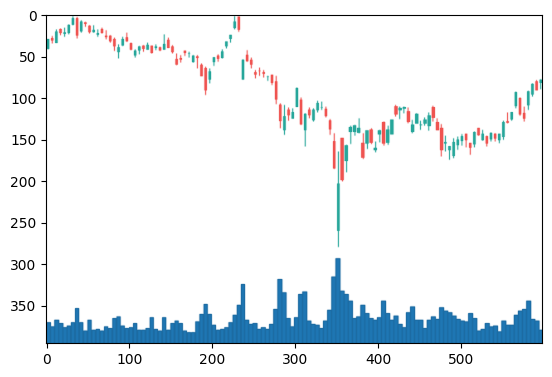

In [151]:
# Use it directly - no pre_render_all() needed!
image, target = chart_dataset_class[91]
print("Target class:", target.item())
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.show()

### Import Libraries 

In [152]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torchvision import transforms, datasets 
from torch.utils.data import DataLoader, random_split 
from tqdm import tqdm 
import time 
from datetime import datetime 

def present_time():
    return datetime.now().strftime('%Y%m%d_%H%M%S')


### Set Seed

In [153]:
import random 

def set_seed(seed: int = 42) -> None:
    """Seed Python, NumPy, and PyTorch (CPU & all GPUs) and 
    make cuDNN run in deterministic mode."""

    # Python and NumPy
    random.seed(seed)
    np.random.seed(seed)

    # PyTorch (CPU & GPU)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    #cuDNN: force repeatable convolutions 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False

In [154]:
SEED = 42 
set_seed(SEED)
print(f"Global seed set to {SEED} -- main process is now deterministic.")

Global seed set to 42 -- main process is now deterministic.


### The Data Pipeline

In [197]:
"""Ensure sequential split (maintain the temporal order) and per-ticker grouping (we don't want to train 
on one ticker's future while testing on another's past)"""
def build_split_indices(dataset: StockCandleChartDataset_Class, train_ratio=0.8, val_ratio=0.2):
    ticker_groups = {}
    for i, (ticker_symbol, end_index) in enumerate(dataset.sample_index):
        ticker_groups.setdefault(ticker_symbol, []).append(i)

    train_idx, val_idx = [], []
    for ticker, indices in ticker_groups.items():
        n = len(indices)
        train_end = int(train_ratio * n)
        val_end = train_end + int(val_ratio * n)
        train_idx.extend(indices[:train_end])
        val_idx.extend(indices[train_end:val_end])
    return train_idx, val_idx

train_idx, val_idx = build_split_indices(chart_dataset_class)

# Ensure sequential split for time series data 
train_dataset = torch.utils.data.Subset(chart_dataset_class, train_idx)
valid_dataset = torch.utils.data.Subset(chart_dataset_class, val_idx)


In [198]:
print(len(train_dataset))
print(len(valid_dataset))

8240
2060


In [199]:
batch_size = 32
num_workers = 0

In [201]:
import numpy as np
import random
from torch.utils.data import Subset

# Get the corresponding labels for train indices
train_labels = [int(chart_dataset_class[i][1].item()) for i in train_idx]

# Split indices by class
class0_idx = [i for i, y in zip(train_idx, train_labels) if y == 0]
class1_idx = [i for i, y in zip(train_idx, train_labels) if y == 1]

print(f"Before undersampling: class0={len(class0_idx)}, class1={len(class1_idx)}")

# Undersample majority class (class 1)
undersampled_class1_idx = random.sample(class1_idx, len(class0_idx))

# Combine and shuffle
balanced_train_idx = class0_idx + undersampled_class1_idx
random.shuffle(balanced_train_idx)

# Create new balanced dataset subset
train_dataset_balanced = Subset(chart_dataset_class, balanced_train_idx)

print(f"After undersampling: total={len(train_dataset_balanced)} (each class={len(class0_idx)})")


Before undersampling: class0=3421, class1=4819
After undersampling: total=6842 (each class=3421)


In [308]:
# --- ADD THIS CODE TO BALANCE YOUR VALIDATION SET ---

# 1. Get the corresponding labels for *validation* indices
val_labels = [int(chart_dataset_class[i][1].item()) for i in val_idx]

# 2. Split validation indices by class
val_class0_idx = [i for i, y in zip(val_idx, val_labels) if y == 0]
val_class1_idx = [i for i, y in zip(val_idx, val_labels) if y == 1]

print(f"Before validation undersampling: class0={len(val_class0_idx)}, class1={len(val_class1_idx)}")

# 3. Find the minority class length (which is class 0 in this case)
n_minority_val = len(val_class0_idx)

# 4. Undersample majority class (class 1)
undersampled_val_class1_idx = random.sample(val_class1_idx, n_minority_val)

# 5. Combine (no shuffle needed for validation)
balanced_val_idx = val_class0_idx + undersampled_val_class1_idx

# 6. Create new balanced validation dataset subset
valid_dataset_balanced = Subset(chart_dataset_class, balanced_val_idx)

print(f"After validation undersampling: total={len(valid_dataset_balanced)} (each class={n_minority_val})")

Before validation undersampling: class0=837, class1=1223
After validation undersampling: total=1674 (each class=837)


In [309]:
train_loader = DataLoader(
    train_dataset_balanced, 
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers,
    pin_memory = True
)

In [310]:
valid_loader = DataLoader(
    valid_dataset_balanced,
    batch_size = batch_size,
    shuffle = False, 
    num_workers = num_workers,
    pin_memory = True
)

### Define the CNN Model

In [311]:
class ConvNet(nn.Module):
    def __init__(self, in_channels: int = 3, feature_channels: int = 64):
        super().__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(in_channels, feature_channels // 2, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels // 2),
            nn.Dropout2d(p=0.3),  # <-- ADD DROPOUT

            # Conv Block 2 - 5
            nn.Conv2d(feature_channels // 2, feature_channels, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels),
            nn.Dropout2d(p=0.4),  # <-- ADD DROPOUT
            
            nn.Conv2d(feature_channels, feature_channels * 2, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels * 2),
            nn.Dropout2d(p=0.3),  # <-- ADD DROPOUT

            nn.Conv2d(feature_channels * 2, feature_channels * 4, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels * 4),
            nn.Dropout2d(p=0.4),  # <-- ADD DROPOUT

            nn.Conv2d(feature_channels * 4, feature_channels * 8, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels * 8),
            nn.Dropout2d(p=0.3),  # <-- ADD DROPOUT

            nn.Conv2d(feature_channels * 8, feature_channels * 16, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(feature_channels * 16),
            nn.Dropout2d(p=0.4),  # <-- ADD DROPOUT
        )

    def forward_features(self, x: torch.Tensor) -> torch.Tensor:
        return self.features(x)

In [328]:
import torchvision.models as models

class ResNetBackbone(nn.Module):
    def __init__(self, freeze_weights=True):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        self.features = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )
        
        # --- ADD THIS LINE ---
        # This forces the output to 7x7, regardless of input size
        # L will now be 7*7 = 49. (L+1 = 50)
        self.pool = nn.AdaptiveAvgPool2d((7, 7))
        # --- END ADDITION ---

        if freeze_weights:
            print("Freezing ResNet backbone weights...")
            for param in self.features.parameters():
                param.requires_grad = False

    def forward(self, x):
        features = self.features(x)
        # --- ADD THIS LINE ---
        features = self.pool(features) # Squash the feature map
        # --- END ADDITION ---
        return features

### PatchEmbed

In [312]:
class PatchEmbed(nn.Module):
    def __init__(self, input_channel = 1024, embed_dim = 768):
        super().__init__()
        self.proj = nn.Conv2d(input_channel, embed_dim, kernel_size = 1)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

### Multi-Head Self-Attention (MHSA) Module

In [313]:
class MHSA(nn.Module):
    def __init__(self, dim, heads = 8, dropout = 0.2):
        super().__init__()
        self.heads = heads 
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.reshape(B, N, self.heads, -1).transpose(1, 2) # B, heads, N, d
        k = k.reshape(B, N, self.heads, -1).transpose(1, 2)
        v = v.reshape(B, N, self.heads, -1).transpose(1, 2)
        attn = torch.matmul(q, k.transpose(-2, -1) * self.scale)
        attn = self.attn_drop(attn.softmax(dim=-1))
        x = torch.matmul(attn, v).transpose(1, 2).reshape(B, N, D)
        return self.proj_drop(self.proj(x))

### Transformer Block

In [314]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio = 4, dropout = 0.2):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MHSA(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

### ViT Model 

In [315]:
class ViT(nn.Module):
    def __init__(self, in_ch=1024, num_classes=2, embed_dim=768, depth=6, heads=6, mlp_ratio=4., dropout=0.2, max_tokens=100):
        super().__init__()
        self.patch = PatchEmbed(in_ch, embed_dim) # 1 x 1 conv
        self.cls = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos = nn.Parameter(torch.randn(1, max_tokens, embed_dim))
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):                        # x: (B,C,H,W)
        x = self.patch(x)                        # (B, L, D)
        B, L, _ = x.shape                        
        cls = self.cls.expand(B, -1, -1)         # (B, 1, D)
        x = torch.cat((cls, x), 1)               # (B, L+1, D)
        x = x + self.pos[:, :L + 1]              # match seq-len
        for blk in self.blocks:
            x = blk(x)
        return self.head(self.norm(x)[:, 0])     # CLS token

### CNN-ViT Hybrid Model

In [316]:
class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, in_channels=3, num_classes = 2, embed_dim = 768, depth = 6, heads = 6):
        super().__init__()
        self.cnn = ConvNet(in_channels=in_channels)
        self.vit = ViT(
            num_classes=num_classes,
            embed_dim = embed_dim,
            depth = depth,
            heads = heads
            )
    
    def forward(self, x):
        return self.vit(self.cnn.forward_features(x))

In [264]:
# class CNN_ViT_Hybrid(nn.Module):
#     def __init__(self, num_classes=2, embed_dim=768, depth=6, heads=6, freeze_backbone=True):
#         super().__init__()
        
#         # 1. Use the new ResNetBackbone
#         self.cnn = ResNetBackbone(freeze_weights=freeze_backbone)
        
#         # 2. The ViT's PatchEmbed MUST accept the backbone's output channels
#         #    ResNet50's layer4 outputs 2048 channels.
#         #    Your original ConvNet output 1024 channels.
#         #    So we change in_ch from 1024 to 2048.
#         self.vit = ViT(
#             in_ch=2048,  # <-- THIS IS THE KEY CHANGE
#             num_classes=num_classes,
#             embed_dim=embed_dim,
#             depth=depth,
#             heads=heads
#         )
    
#     def forward(self, x):
#         # Pass image through ResNet to get feature maps
#         features = self.cnn(x)
#         # Pass feature maps to ViT
#         return self.vit(features)

In [288]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [317]:
data_augmentation = transforms.Compose([
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomAffine(degrees=0, shear=5, scale=(0.95, 1.05)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value = 0),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], 
    std=[0.229, 0.224, 0.225]
)

### Model Training 

In [318]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    loss_sum, correct = 0, 0
    scaler = torch.cuda.amp.GradScaler()

    for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Training")):
        # Normalize pixels from [0, 255] to [0, 1]
        x = x / 255.0
        x = data_augmentation(x)
        
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        y = y.long()

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast():
            out = model(x)
            loss = criterion(out, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if batch_idx % 100 == 0:
            print("Scaler scale:", scaler.get_scale())

        loss_sum += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()

    return loss_sum / len(loader.dataset), correct / len(loader.dataset)


### Validation Function

In [319]:
def evaluate(model, loader, criterion, device):
    model.eval()
    loss_sum, correct = 0, 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Validation")):
                        # Normalize pixels from [0, 255] to [0, 1]
            x = x / 255.0
            # x = val_transforms(x)
            
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y = y.long()

            with torch.cuda.amp.autocast():  # ✅
                out = model(x)
                loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)


In [329]:
# --- NEW, SIMPLE CLASSIFIER HEAD ---
# This replaces PatchEmbed, MHSA, TransformerBlock, and ViT
class ClassifierHead(nn.Module):
    def __init__(self, in_features=2048, num_classes=2, dropout=0.5):
        super().__init__()
        # This will pool the (B, 2048, 7, 7) output from ResNet
        # down to (B, 2048, 1, 1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout)
        # A simple linear layer
        self.linear = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        return x

# --- NEW FINAL MODEL ---
# This replaces your CNN_ViT_Hybrid class
class FinalModel(nn.Module):
    def __init__(self, num_classes=2, freeze_backbone=True):
        super().__init__()
        # 1. Use the ResNetBackbone
        self.backbone = ResNetBackbone(freeze_weights=freeze_backbone)
        
        # 2. Use the NEW simple head
        self.head = ClassifierHead(in_features=2048, num_classes=num_classes)
    
    def forward(self, x):
        # Pass image through ResNet to get (B, 2048, 7, 7) features
        features = self.backbone(x)
        # Pass features to the simple head to get (B, 2) logits
        return self.head(features)

### Initiate Training

In [330]:

lr = 0.0003
epochs = 15
attn_heads = 6
depth = 6
embed_dim = 768
batch_size = 32
num_cls = 2


In [321]:
# --- Add this in a new cell ---
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    Correct FocalLoss implementation that handles class weights (alpha).
    """
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        # alpha is expected to be a tensor of weights, 
        # e.g., [weight_for_class_0, weight_for_class_1]
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        # Calculate CE loss without reduction to get per-sample loss
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Get probabilities of the true class
        pt = torch.exp(-ce_loss)
        
        # Get the alpha weight for EACH sample's target class
        # if self.alpha is not None:
        #     alpha_t = self.alpha.to(inputs.device)[targets]
        # else:
        #     alpha_t = 1.0 # If no alpha, use 1 for all
        if isinstance(self.alpha, torch.Tensor):
            alpha_t = self.alpha.to(inputs.device)[targets]
        else:
            alpha_t = float(self.alpha)  # scalar weight

        # Calculate focal loss: alpha * (1 - p_t)^gamma * ce_loss
        focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [323]:
print(f"Training the model on {device}")

# lr=0.0003


print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model_dict_name = f"ai_capstone_pytorch_vit_model_state_dict.pth"

model = CNN_ViT_Hybrid(
    in_channels=3,
    num_classes=num_cls,
    heads=attn_heads,
    depth=depth,
    embed_dim=embed_dim
).to(device)

# To this:
# model = FinalModel(
#     num_classes=num_cls,
#     freeze_backbone=True
# ).to(device)

# model = CNN_ViT_Hybrid(
#     num_classes=num_cls,
#     heads=attn_heads,
#     depth=depth,
#     embed_dim=embed_dim,
#     freeze_backbone=True # Start with weights frozen
# ).to(device)

# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


# class_weights = torch.tensor([1.2043, 0.8549], dtype=torch.float).to(device)

# --- THIS IS THE FIX ---
# Use the NEW FocalLoss, passing in both alpha (for class count) 
# and gamma (for easy/hard difficulty)
criterion = FocalLoss(alpha=1, gamma=3.0) 
# ---

# criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=class_weights) # <-- This is the key

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',        # we want to minimize validation loss
    factor=0.5,        # shrink LR by half
    patience=3,        # wait 3 epochs with no improvement
    # verbose=True,      # print LR updates
    min_lr=1e-6        # don’t go below this
)


best_loss = float('inf')
tr_loss_all = []
te_loss_all = []
tr_acc_all = []
te_acc_all = [] 

training_time = []

for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch: 02d}/{epochs:02d} started at {present_time()}")
    tr_loss, tr_acc = train(model, train_loader, optimizer, criterion, device) # Former gets the loss, latter gets the acc (just the way it is)
    te_loss, te_acc = evaluate(model, valid_loader, criterion, device)
    ##
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {te_loss:.4f} acc {te_acc:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    tr_loss_all.append(tr_loss)
    te_loss_all.append(te_loss)
    tr_acc_all.append(tr_acc)
    te_acc_all.append(te_acc)
    training_time.append(time.time() - start_time)

    # save the best model 
    avg_te_loss = te_loss
    if avg_te_loss < best_loss:
        print(f"Current loss ({avg_te_loss:.04f}) lower than previous best loss ({ best_loss:.04f}), Saving current model state")
        best_loss = avg_te_loss
        torch.save(model.state_dict(), model_dict_name)
        
print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")


print(f"\nTraining completed!")

# # Test on test set
# print(f"\n{'='*60}")
# print("Testing on held-out test set...")
# print(f"{'='*60}")

# Load best model
# model.load_state_dict(torch.load(model_dict_name))

# # Test
# # test_loss = test(model, test_loader, criterion, device)
# test_loss, test_acc = test(model, test_loader, criterion, device)
# # print(f"\nTest Loss: {test_loss:.6f}")
# print(f"\nTest Loss: {test_loss:.6f} | Test Accuracy: {test_acc:.6f}")


Training the model on cuda
epochs:15 | batch:32 | attn_heads:6 | depth:6 | embed_dim:768


C:\Users\sekai\AppData\Local\Temp\ipykernel_1784\2104801079.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch  1/15 started at 20251116_222038


Training:   0%|          | 0/214 [00:00<?, ?it/s]C:\Users\sekai\AppData\Local\Temp\ipykernel_1784\2104801079.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training:   0%|          | 1/214 [00:00<01:50,  1.92it/s]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [00:44<00:50,  2.23it/s]

Scaler scale: 16384.0


Training:  94%|█████████▍| 201/214 [01:27<00:05,  2.38it/s]

Scaler scale: 16384.0


Validation:   0%|          | 0/53 [00:00<?, ?it/s]C:\Users\sekai\AppData\Local\Temp\ipykernel_1784\2872781388.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # ✅
Validation: 100%|██████████| 53/53 [00:12<00:00,  4.31it/s]


Epoch 01 | train loss 0.1846 acc 0.5015 | val loss 0.0890 acc 0.5000 | in  104.81s
Current loss (0.0890) lower than previous best loss (inf), Saving current model state

Epoch  2/15 started at 20251116_222223


Training:   0%|          | 1/214 [00:00<01:28,  2.40it/s]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [00:42<00:47,  2.36it/s]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [01:25<00:05,  2.32it/s]

Scaler scale: 65536.0


Validation: 100%|██████████| 53/53 [00:12<00:00,  4.35it/s]


Epoch 02 | train loss 0.0922 acc 0.4942 | val loss 0.0942 acc 0.5000 | in  102.70s

Epoch  3/15 started at 20251116_222406


Training:   0%|          | 1/214 [00:00<01:27,  2.44it/s]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [00:42<00:47,  2.38it/s]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [01:23<00:05,  2.40it/s]

Scaler scale: 65536.0


Validation: 100%|██████████| 53/53 [00:12<00:00,  4.28it/s]


Epoch 03 | train loss 0.0914 acc 0.5000 | val loss 0.0888 acc 0.5000 | in  101.41s
Current loss (0.0888) lower than previous best loss (0.0890), Saving current model state

Epoch  4/15 started at 20251116_222547


Training:   0%|          | 1/214 [00:00<01:26,  2.45it/s]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [00:43<00:47,  2.36it/s]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [01:25<00:05,  2.37it/s]

Scaler scale: 65536.0


Validation: 100%|██████████| 53/53 [00:12<00:00,  4.30it/s]


Epoch 04 | train loss 0.0923 acc 0.4969 | val loss 0.0955 acc 0.5000 | in  103.14s

Epoch  5/15 started at 20251116_222730


Training:   0%|          | 1/214 [00:00<01:37,  2.19it/s]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [00:42<00:47,  2.37it/s]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [01:25<00:05,  2.29it/s]

Scaler scale: 65536.0


Validation: 100%|██████████| 53/53 [00:12<00:00,  4.24it/s]


Epoch 05 | train loss 0.0896 acc 0.5224 | val loss 0.0866 acc 0.5018 | in  103.24s
Current loss (0.0866) lower than previous best loss (0.0888), Saving current model state

Epoch  6/15 started at 20251116_222914


Training:   0%|          | 1/214 [00:00<01:32,  2.31it/s]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [00:43<00:47,  2.37it/s]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [01:26<00:05,  2.32it/s]

Scaler scale: 65536.0


Validation: 100%|██████████| 53/53 [00:12<00:00,  4.09it/s]


Epoch 06 | train loss 0.0894 acc 0.5086 | val loss 0.0876 acc 0.5000 | in  104.53s

Epoch  7/15 started at 20251116_223058


Training:   0%|          | 1/214 [00:00<01:31,  2.33it/s]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [00:44<00:48,  2.34it/s]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [01:25<00:05,  2.44it/s]

Scaler scale: 65536.0


Validation: 100%|██████████| 53/53 [00:12<00:00,  4.17it/s]


Epoch 07 | train loss 0.0899 acc 0.5191 | val loss 0.0866 acc 0.5251 | in  104.05s
Current loss (0.0866) lower than previous best loss (0.0866), Saving current model state

Epoch  8/15 started at 20251116_223243


Training:   0%|          | 1/214 [00:00<01:31,  2.34it/s]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [00:44<00:53,  2.10it/s]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [01:32<00:05,  2.20it/s]

Scaler scale: 65536.0


Validation: 100%|██████████| 53/53 [00:13<00:00,  4.06it/s]


Epoch 08 | train loss 0.0882 acc 0.5262 | val loss 0.0866 acc 0.5203 | in  111.22s

Epoch  9/15 started at 20251116_223434


Training:   0%|          | 1/214 [00:00<01:32,  2.30it/s]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [00:45<00:51,  2.20it/s]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [01:30<00:05,  2.32it/s]

Scaler scale: 65536.0


Validation: 100%|██████████| 53/53 [00:12<00:00,  4.31it/s]


Epoch 09 | train loss 0.0876 acc 0.5367 | val loss 0.0868 acc 0.5143 | in  107.80s

Epoch  10/15 started at 20251116_223622


Training:   0%|          | 1/214 [00:00<01:27,  2.44it/s]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [00:43<00:48,  2.34it/s]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [01:26<00:05,  2.34it/s]

Scaler scale: 65536.0


Validation: 100%|██████████| 53/53 [00:12<00:00,  4.17it/s]


Epoch 10 | train loss 0.0879 acc 0.5399 | val loss 0.0981 acc 0.5000 | in  104.76s

Epoch  11/15 started at 20251116_223806


Training:   0%|          | 1/214 [00:00<01:36,  2.21it/s]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [00:44<00:55,  2.03it/s]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [01:33<00:06,  2.15it/s]

Scaler scale: 65536.0


Validation: 100%|██████████| 53/53 [00:13<00:00,  3.97it/s]


Epoch 11 | train loss 0.0864 acc 0.5558 | val loss 0.0873 acc 0.5185 | in  112.38s

Epoch  12/15 started at 20251116_223959


Training:   0%|          | 1/214 [00:00<01:35,  2.23it/s]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [00:45<00:48,  2.35it/s]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [01:29<00:05,  2.20it/s]

Scaler scale: 65536.0


Validation: 100%|██████████| 53/53 [00:13<00:00,  4.05it/s]


Epoch 12 | train loss 0.0868 acc 0.5566 | val loss 0.0862 acc 0.5412 | in  108.48s
Current loss (0.0862) lower than previous best loss (0.0866), Saving current model state

Epoch  13/15 started at 20251116_224148


Training:   0%|          | 1/214 [00:00<01:46,  2.00it/s]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [00:44<00:50,  2.24it/s]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [01:28<00:05,  2.30it/s]

Scaler scale: 65536.0


Validation: 100%|██████████| 53/53 [00:13<00:00,  3.98it/s]


Epoch 13 | train loss 0.0856 acc 0.5731 | val loss 0.0884 acc 0.5036 | in  107.65s

Epoch  14/15 started at 20251116_224335


Training:   0%|          | 1/214 [00:00<01:37,  2.19it/s]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [00:43<00:49,  2.29it/s]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [01:27<00:05,  2.22it/s]

Scaler scale: 65536.0


Validation: 100%|██████████| 53/53 [00:13<00:00,  4.06it/s]


Epoch 14 | train loss 0.0857 acc 0.5687 | val loss 0.0885 acc 0.5024 | in  105.88s

Epoch  15/15 started at 20251116_224521


Training:   0%|          | 1/214 [00:00<01:44,  2.05it/s]

Scaler scale: 65536.0


Training:  47%|████▋     | 101/214 [00:44<00:48,  2.31it/s]

Scaler scale: 65536.0


Training:  94%|█████████▍| 201/214 [01:27<00:05,  2.26it/s]

Scaler scale: 65536.0


Validation: 100%|██████████| 53/53 [00:12<00:00,  4.09it/s]

Epoch 15 | train loss 0.0846 acc 0.5861 | val loss 0.0906 acc 0.5287 | in  106.37s
epochs:15 | batch:32 | attn_heads:6 | depth:6 | embed_dim:768

Training completed!


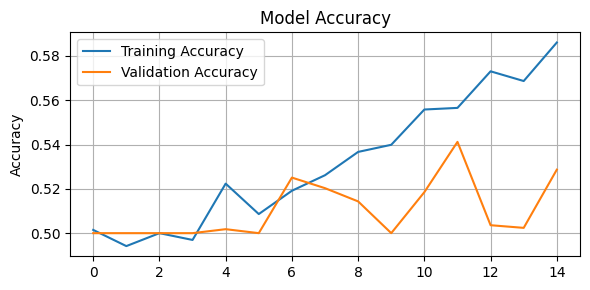

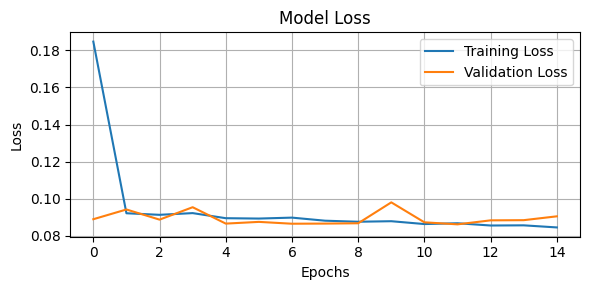

In [324]:
import matplotlib.pyplot as plt


fig_w, fig_h = 6, 3
fig, axs = plt.subplots(figsize=(fig_w, fig_h))

# Plot Accuracy on the first subplot 
axs.plot(tr_acc_all, label="Training Accuracy")
axs.plot(te_acc_all, label="Validation Accuracy")
axs.set_title("Model Accuracy")
axs.set_ylabel("Accuracy")
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(figsize=(fig_w, fig_h))

# Plot loss on the second subplot 
axs.plot(tr_loss_all, label="Training Loss")
axs.plot(te_loss_all, label="Validation Loss")
axs.set_title("Model Loss")
axs.set_xlabel("Epochs")
axs.set_ylabel("Loss")
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

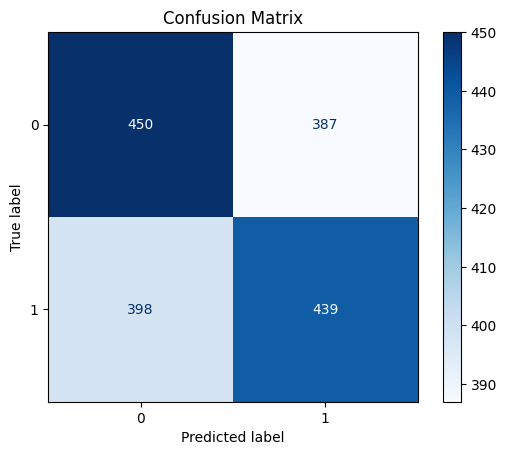

Class 0: 53.76% accuracy
Class 1: 52.45% accuracy


In [325]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set model to evaluation mode
model.load_state_dict(torch.load(model_dict_name))
model.eval()

all_preds = []
all_labels = []

# Disable gradient calculation for efficiency
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)

        images = images / 255.0
        # images = val_transforms(images)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optionally normalize it (set normalize='true' for percentages)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

%matplotlib inline

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# If you want class-wise accuracy:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i, acc in enumerate(np.diag(cm_normalized)):
    print(f"Class {i}: {acc*100:.2f}% accuracy")
